In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

# import pandas
import pandas as pd

# import train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer


In [24]:
data = pd.read_csv("../data/df_pooled_common.csv")
data.head()


,nome,ida,diff_fase,ponto_virada_encoded,anos_pm,bolsista_encoded,ipv,corraca,ponto_virada,ian,...,ips,ieg,ipp,idade,sexo_encoded,fase,inde,sexo,na_fase,ano
0,ALUNO-1,7.000000,0.0,0,2.0,0,7.750000,R,Não,10.0,...,7.500,8.7,5.9375,11.0,1.0,2,7.883752,F,1,2020
1,ALUNO-3,5.500000,0.0,0,2.0,0,8.111113,B,Não,10.0,...,7.500,8.9,8.1250,12.0,1.0,3,7.856390,F,1,2020
2,ALUNO-4,0.000000,-1.0,0,2.0,0,7.750000,R,Não,5.0,...,6.875,4.1,7.1875,10.0,0.0,1,5.076252,M,0,2020
3,ALUNO-5,7.500000,0.0,0,1.0,0,8.166665,R,Não,10.0,...,7.500,8.0,8.4375,10.0,0.0,2,8.077085,M,1,2020
4,ALUNO-8,7.333333,0.0,1,3.0,1,8.944450,R,Sim,10.0,...,4.375,9.9,8.7500,14.0,1.0,4,8.381391,F,1,2020


In [25]:
data = data.drop(columns=["pedra_encoded", "nome"])

# transforma bolsista em categoria sim/não
data["bolsista"] = (
    data["bolsista_encoded"]
    .apply(lambda x: "sim" if x == 1 else "não")
    .astype("category")
)

data.drop(columns=["bolsista_encoded"], inplace=True)

# transforma pedra em categoria
data["pedra"] = data["pedra"].astype("category")

# maps ano to t,t+1,t+2
data["ano"] = data["ano"].apply(
    lambda x: "t0" if x == 2020 else ("t1" if x == 2021 else "t2")
)
data["ano"] = data["ano"].astype("category")

data.head()


,ida,diff_fase,ponto_virada_encoded,anos_pm,ipv,corraca,ponto_virada,ian,pedra,iaa,...,ieg,ipp,idade,sexo_encoded,fase,inde,sexo,na_fase,ano,bolsista
0,7.000000,0.0,0,2.0,7.750000,R,Não,10.0,Ametista,8.50002,...,8.7,5.9375,11.0,1.0,2,7.883752,F,1,t0,não
1,5.500000,0.0,0,2.0,8.111113,B,Não,10.0,Ametista,7.91667,...,8.9,8.1250,12.0,1.0,3,7.856390,F,1,t0,não
2,0.000000,-1.0,0,2.0,7.750000,R,Não,5.0,Quartzo,8.00002,...,4.1,7.1875,10.0,0.0,1,5.076252,M,0,t0,não
3,7.500000,0.0,0,1.0,8.166665,R,Não,10.0,Ametista,7.50002,...,8.0,8.4375,10.0,0.0,2,8.077085,M,1,t0,não
4,7.333333,0.0,1,3.0,8.944450,R,Sim,10.0,Ametista,8.33334,...,9.9,8.7500,14.0,1.0,4,8.381391,F,1,t0,sim


In [26]:
# Selecionar as variáveis preditoras e a variável alvo
# no lugar de eliminar o ano, será que daria para usar uma espécie de nota no ano t, nota no ano t+1, nota em t + 2?
X = data.drop(columns=["inde", "bolsista"])

X = X[["anos_pm", "fase", "ida", "ipv", "ieg", "idade", "ipp", "na_fase", "sexo"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, data["bolsista"], test_size=0.25, random_state=41, shuffle=True
)


In [27]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)


In [28]:
label = "bolsista"
print("Summary of class variable: \n", train_data[label].describe())


Summary of class variable: 
 count     1688
unique       2
top        não
freq      1430
Name: bolsista, dtype: object


In [29]:
print(X_train.describe())
print(y_train.describe())


           anos_pm         fase          ida          ipv          ieg  \
count  1688.000000  1688.000000  1688.000000  1688.000000  1688.000000   
mean      1.558649     2.305095     5.967858     7.370089     7.570527   
std       1.513072     1.853220     2.389013     1.333416     2.097586   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     4.600000     6.800000     6.400000   
50%       1.000000     2.000000     6.333333     7.500000     8.200000   
75%       3.000000     3.000000     7.666667     8.200000     9.200000   
max       6.000000     7.000000    10.000000    10.000010    10.000000   

             idade          ipp      na_fase  
count  1686.000000  1688.000000  1688.000000  
mean     12.283511     7.012319     0.357820  
std       2.629718     1.388205     0.479501  
min       7.000000     0.000000     0.000000  
25%      10.000000     6.250000     0.000000  
50%      12.000000     7.343750     0.000000  
75% 

In [30]:
save_path = "agModels-predictBolsista"  # specifies folder to store trained models
predictor = TabularPredictor(
    label=label,
    path=save_path,
).fit(train_data, presets="good_quality", num_gpus=1)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Mar 29 23:14:13 UTC 2024
CPU Count:          16
Memory Avail:       2.50 GB / 15.49 GB (16.1%)
Disk Space Avail:   914.22 GB / 1006.85 GB (90.8%)
Presets specified: ['good_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected

In [35]:
y_test = test_data[label]  # values to predict
test_data_nolab = X_test  # delete label column to prove we're not cheating
test_data_nolab.head()


,anos_pm,fase,ida,ipv,ieg,idade,ipp,na_fase,sexo
272,0.0,0,5.750000,5.916675,10.000000,8.0,2.50000,1,M
15,2.0,2,7.000000,7.944443,9.300000,12.0,8.12500,0,F
1815,0.0,3,5.166667,8.277780,9.136364,13.0,7.96875,1,M
387,2.0,2,9.000000,8.333335,8.200000,10.0,7.50000,1,M
1363,5.0,7,5.800000,5.400000,7.200000,17.0,6.70000,1,M


In [36]:
print(predictor.feature_metadata)


('category', [])  : 1 | ['sexo']
('float', [])     : 6 | ['anos_pm', 'ida', 'ipv', 'ieg', 'idade', ...]
('int', [])       : 1 | ['fase']
('int', ['bool']) : 1 | ['na_fase']


In [37]:
# predictor = TabularPredictor.load(
#     save_path
# )  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(
    y_true=y_test, y_pred=y_pred, auxiliary_metrics=True
)


Predictions:  
 272     não
15      não
1815    não
387     não
1363    sim
       ... 
556     não
491     não
109     não
1121    sim
1976    não
Name: bolsista, Length: 563, dtype: object


In [39]:
print(perf)


{'accuracy': 0.9094138543516874, 'balanced_accuracy': 0.7847822845213241, 'mcc': 0.6188171555228905, 'f1': 0.6666666666666666, 'precision': 0.7391304347826086, 'recall': 0.6071428571428571}


In [40]:
results = predictor.fit_summary(show_plot=True)


*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          NeuralNetTorch_BAG_L1   0.931280    accuracy       0.153149   89.648796                0.153149          89.648796            1      False         10
1         NeuralNetFastAI_BAG_L1   0.931280    accuracy       1.056858  322.803923                1.056858         322.803923            1      False          8
2            WeightedEnsemble_L2   0.931280    accuracy       1.058576  323.117744                0.001718           0.313822            2      False         12
3              LightGBMXT_BAG_L1   0.930687    accuracy       0.101023    2.280487                0.101023           2.280487            1      False          1
4                LightGBM_BAG_L1   0.930687    accuracy       0.177161    3.982239                0.177161           3.982239        

gio: file:///home/alien-wsl/projects/datathon_app/datathonapp/notebooks/agModels-predictBolsistaSummaryOfModels.html: Failed to find default application for content type ‘text/html’


In [41]:
predictor.feature_importance(test_data)


Computing feature importance via permutation shuffling for 9 features using 563 rows with 5 shuffle sets...
	1.93s	= Expected runtime (0.39s per shuffle set)
	0.45s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
fase,0.084547,0.015362,0.000125,5,0.116177,0.052917
anos_pm,0.074245,0.006925,0.000009,5,0.088504,0.059987
ida,0.019183,0.007783,0.002644,5,0.035208,0.003158
na_fase,0.013144,0.004089,0.000993,5,0.021563,0.004724
ieg,0.009591,0.007388,0.021991,5,0.024803,-0.005620
idade,0.008881,0.004528,0.005913,5,0.018205,-0.000443
ipp,0.008526,0.004423,0.006270,5,0.017632,-0.000581
ipv,0.005684,0.005944,0.049650,5,0.017923,-0.006556
sexo,-0.001066,0.003227,0.749415,5,0.005578,-0.007709


In [42]:
features_importance = predictor.feature_importance(test_data)


Computing feature importance via permutation shuffling for 9 features using 563 rows with 5 shuffle sets...
	1.78s	= Expected runtime (0.36s per shuffle set)
	0.42s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [43]:
print(features_importance[features_importance["importance"] > 0].index.tolist())


['fase', 'anos_pm', 'ida', 'na_fase', 'ieg', 'idade', 'ipp', 'ipv']


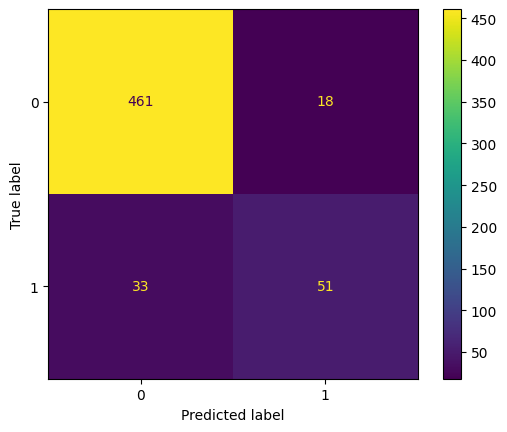

In [54]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)


cm_display.plot()
plt.show()


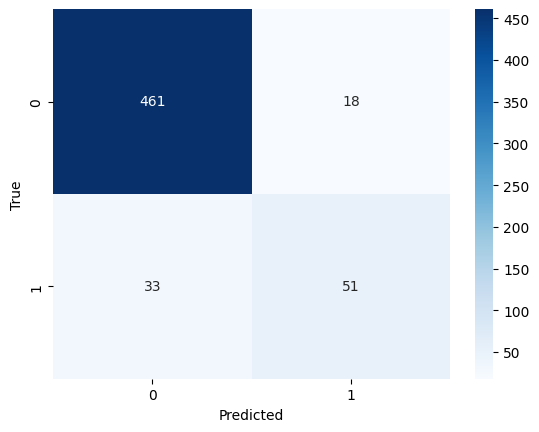

In [51]:
import seaborn as sns

cm = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
